In [79]:
import kaggle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the path to the download directory
download_path = './data'
    
# Ensure the download directory exists
os.makedirs(download_path, exist_ok=True)
    
# Download the dataset
kaggle.api.authenticate()
kaggle.api.dataset_download_files('claygendron/us-household-income-by-zip-code-2021-2011', path=download_path, unzip=True)
# Need to specify type for ZIP column as 'str' otherwise zip codes starting with '0' are not represented correctly.
df = pd.read_csv(f"{download_path}/us_income_zipcode.csv", dtype = {'ZIP': str})

Dataset URL: https://www.kaggle.com/datasets/claygendron/us-household-income-by-zip-code-2021-2011


In [72]:
df.shape

(364998, 111)

In [81]:
# We'll need just a few columns from the dataset
income = df[['ZIP', 'Households Mean Income (Dollars)', 'Households Median Income (Dollars)','Year']]

In [82]:
# We'll use the latest year available in the dataset
income_2021 = income[income['Year'] == 2021]

In [86]:
print(income_2021.dtypes)

ZIP                                    object
Households Mean Income (Dollars)      float64
Households Median Income (Dollars)    float64
Year                                  float64
dtype: object


In [84]:
print(income_2021['ZIP'])

0        00601
1        00602
2        00603
3        00606
4        00610
         ...  
33769    99923
33770    99925
33771    99926
33772    99927
33773    99929
Name: ZIP, Length: 33774, dtype: object


In [88]:
# Let's review the data
print(income_2021.sort_values(by='Households Median Income (Dollars)', ascending=False))

         ZIP  Households Mean Income (Dollars)  \
570    02481                          361264.0   
6899   22066                          329208.0   
6789   21723                          212173.0   
2695   10514                          328018.0   
29024  82944                          193787.0   
...      ...                               ...   
12341  37376                           25106.0   
16435  48743                               NaN   
23693  67232                           70565.0   
26947  76429                           50062.0   
7086   22904                           98912.0   

       Households Median Income (Dollars)    Year  
570                              249375.0  2021.0  
6899                             247730.0  2021.0  
6789                             247284.0  2021.0  
2695                             246991.0  2021.0  
29024                            246080.0  2021.0  
...                                   ...     ...  
12341                              

In [87]:
# After checking the data, it looks like there are a few rows that should be omitted as they seem to contain false information.
# We'll omit the rows where 'Households Median Income (Dollars)' equals exactly $250000, those are outliers.
income_2021 = income_2021[income_2021['Households Median Income (Dollars)'].lt(250000)]

In [39]:
# Download the shape files from census.gov
import wget
wget.download("https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/tl_2020_us_zcta520.zip")
# download takes a few minutes

-1 / unknown

'tl_2020_us_zcta520.zip'

In [42]:
# Unzip
import zipfile
with zipfile.ZipFile(os.getcwd()+'\\tl_2020_us_zcta520.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd()+'\\tl_2020_us_zcta520_unzipped')

In [90]:
import geopandas as gpd
gdf = gpd.read_file(os.getcwd()+'\\tl_2020_us_zcta520_unzipped')

In [24]:
gdf.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.6539, -88.24713 33.6541..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.3496, -86.81648 34.3496..."
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."


In [91]:
print(gdf.dtypes)

ZCTA5CE20       object
GEOID20         object
CLASSFP20       object
MTFCC20         object
FUNCSTAT20      object
ALAND20          int64
AWATER20         int64
INTPTLAT20      object
INTPTLON20      object
geometry      geometry
dtype: object


In [46]:
gdf.shape

(33791, 10)

In [92]:
gdf_merged = gdf.merge(income_2021,left_on='ZCTA5CE20',right_on='ZIP')

In [93]:
gdf_merged.shape

(30611, 14)

In [94]:
# We'll use latitude filter to remove Alaska, Hawaii and Puerto Rico data
gdf_merged['INTPTLAT20'] = gdf_merged['INTPTLAT20'].astype(float)
gdf_merged_filtered = gdf_merged[gdf_merged['INTPTLAT20'].lt(50)]
gdf_merged_filtered = gdf_merged_filtered[gdf_merged_filtered['INTPTLAT20'].gt(24)]

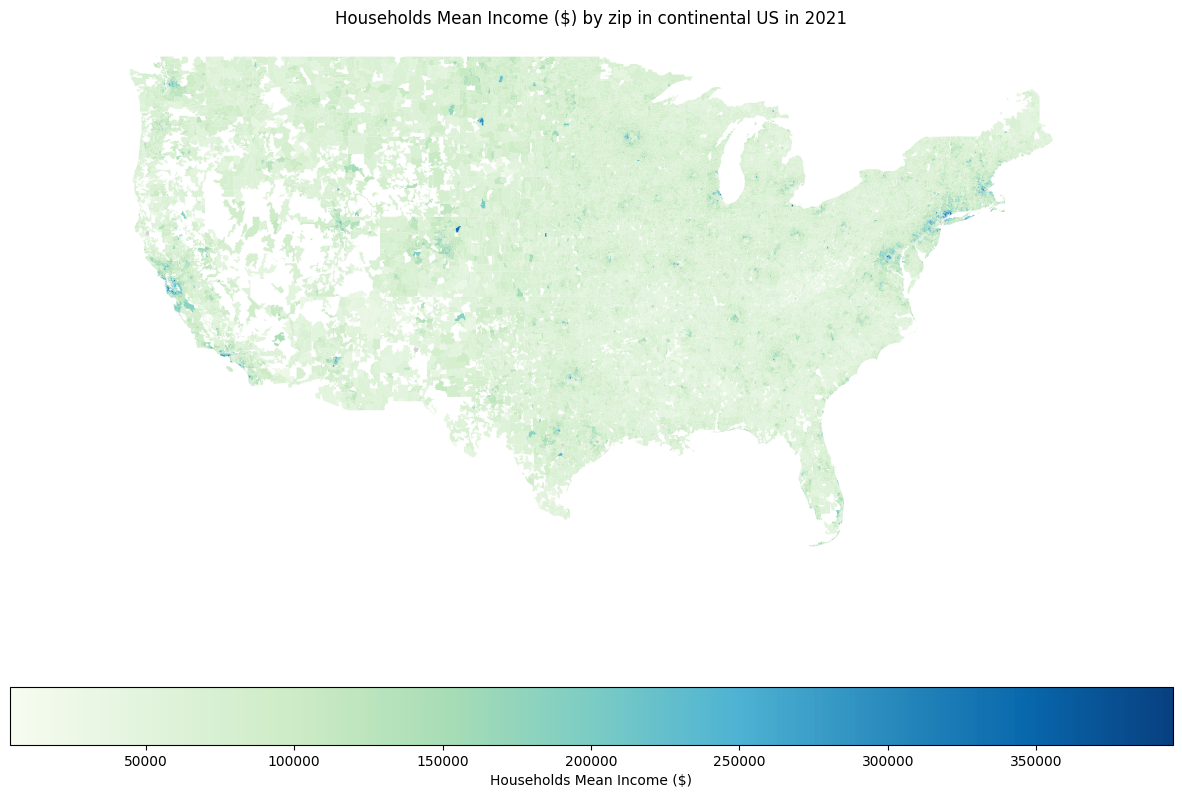

In [96]:
# Median Household Income by zip code
ax = gdf_merged_filtered.plot(
        column='Households Mean Income (Dollars)',
        legend=True,
        legend_kwds={
            "label": "Households Mean Income ($)",
            "orientation": "horizontal"},
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "lightgray",
            "hatch": "///",
            "label": "Missing values",
        },
        figsize=(15, 10),
        cmap='GnBu');
ax.set_axis_off();
ax.set_title('Households Mean Income ($) by zip in continental US in 2021');